In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [25]:
dataset=pd.read_csv('SMSSpamCollection.csv',sep='\t',names=['label','message'])
print(dataset)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [26]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [27]:
dataset.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [28]:
dataset['label']=dataset['label'].map({'ham':0,'spam':1})
dataset

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

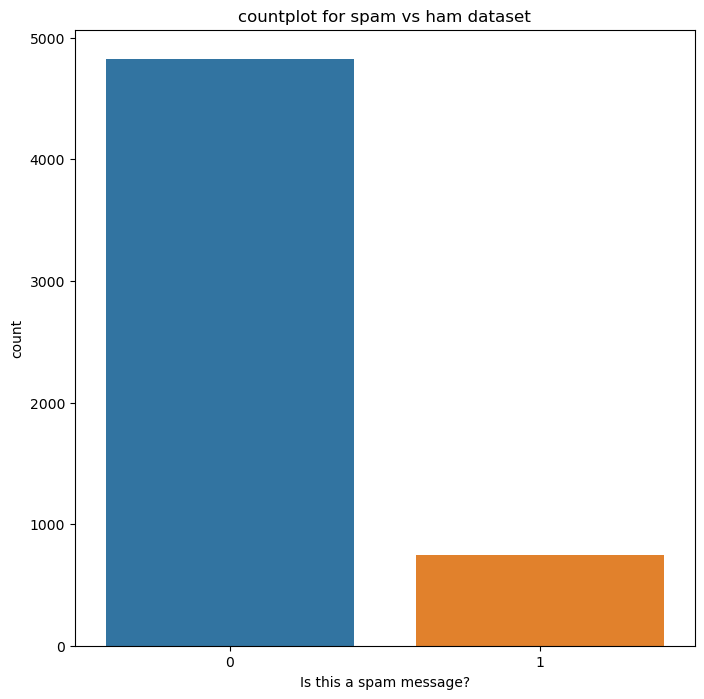

In [30]:
#countplot for spam vs ham dataset
plt.figure(figsize=(8,8))
g=sns.countplot(x='label',data=dataset)
p=plt.title("countplot for spam vs ham dataset")
p=plt.xlabel("Is this a spam message?")
p=plt.ylabel("count")

In [31]:
#Handling imbalanced dataset using oversampling
only_spam=dataset[dataset['label']==1]
only_spam

,label,message
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [32]:
count=int((dataset.shape[0]-only_spam.shape[0])/only_spam.shape[0])
print(count)

6


In [33]:
dataset.shape

(5572, 2)

In [34]:
for i in range(count-1):
    dataset=pd.concat([dataset,only_spam])
    
dataset.shape

(9307, 2)

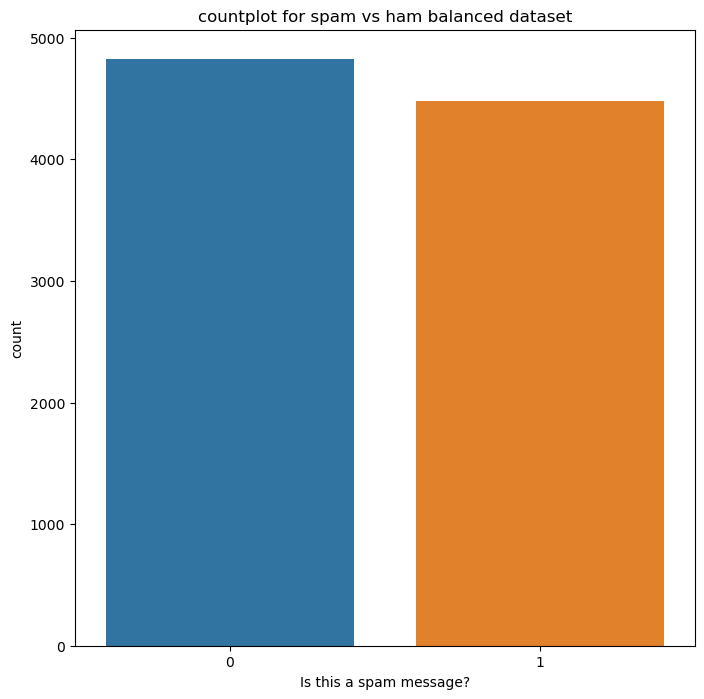

In [35]:
#countplot for spam vs ham dataset
plt.figure(figsize=(8,8))
g=sns.countplot(x='label',data=dataset)
p=plt.title("countplot for spam vs ham balanced dataset")
p=plt.xlabel("Is this a spam message?")
p=plt.ylabel("count")

In [36]:
dataset['word_count']=dataset['message'].apply(lambda x:len(x.split()))

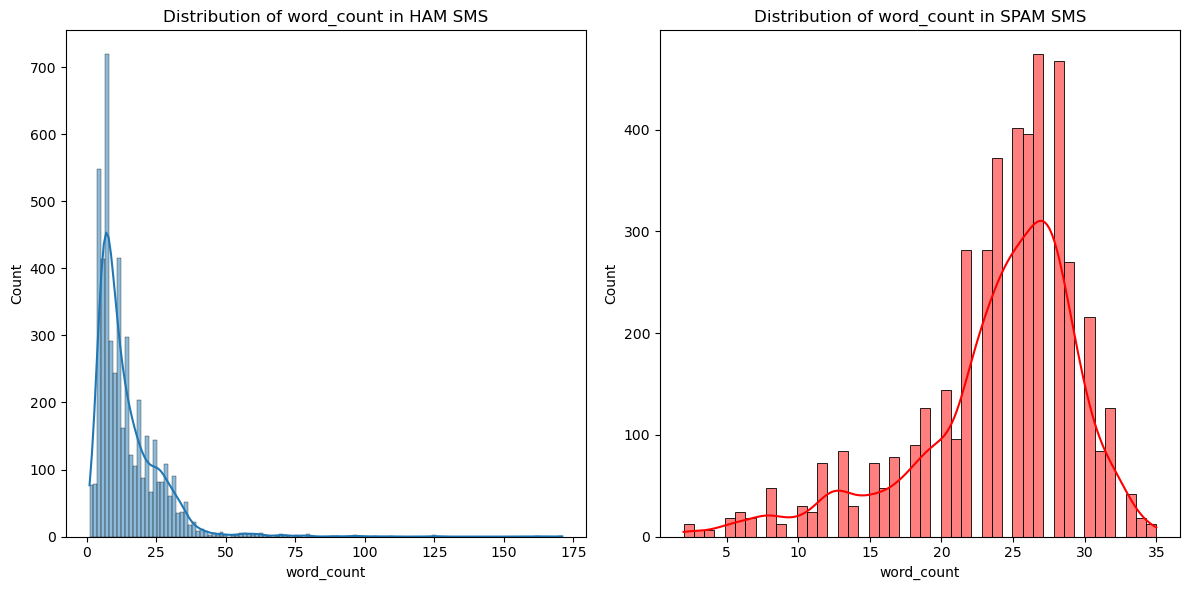

In [37]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
g=sns.histplot(dataset[dataset['label']==0].word_count,kde=True)
p=plt.title("Distribution of word_count in HAM SMS")

plt.subplot(1,2,2)
g=sns.histplot(dataset[dataset['label']==1].word_count,color='red',kde=True)
p=plt.title("Distribution of word_count in SPAM SMS")

plt.tight_layout()
plt.show()


In [38]:
#Creating a new feature containing currency symbols
def currency(data):
    currency_symbols=['$', '€', '£', '¥', '₹']
    for i in currency_symbols:
        if i in data:
            return 1
    return 0

In [40]:
dataset["contains_currency_symbols"]=dataset["message"].apply(currency)
dataset

,label,message,word_count,contains_currency_symbols
0,0,"Go until jurong point, crazy.. Available only ...",20,0
1,0,Ok lar... Joking wif u oni...,6,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,0
3,0,U dun say so early hor... U c already then say...,11,0
4,0,"Nah I don't think he goes to usf, he lives aro...",13,0
...,...,...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...,16,0
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,33,1
5547,1,Had your contract mobile 11 Mnths? Latest Moto...,28,0
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...,28,0


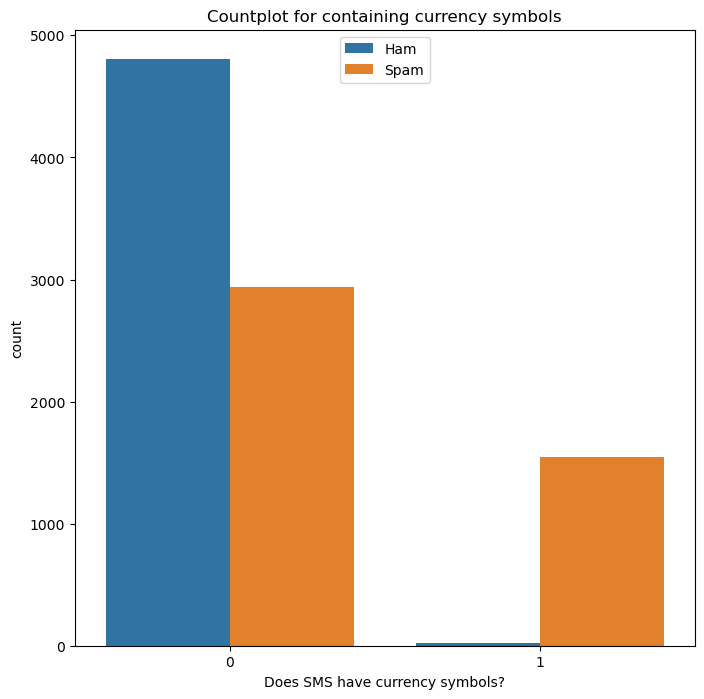

In [41]:
plt.figure(figsize=(8,8))
g=sns.countplot(x='contains_currency_symbols',data=dataset,hue="label")
p=plt.title("Countplot for containing currency symbols")
p=plt.xlabel("Does SMS have currency symbols?")
p=plt.ylabel("count")
p=plt.legend(labels=['Ham','Spam'],loc=9)


In [42]:
#creating new feature containing numbers
def number(data):
    for i in data:
        if ord(i)>=48 and ord(i)<=57:
            return 1
    return 0

In [43]:
dataset["contains_numbers"]=dataset["message"].apply(number)
dataset

,label,message,word_count,contains_currency_symbols,contains_numbers
0,0,"Go until jurong point, crazy.. Available only ...",20,0,0
1,0,Ok lar... Joking wif u oni...,6,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,0,1
3,0,U dun say so early hor... U c already then say...,11,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",13,0,0
...,...,...,...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...,16,0,1
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,33,1,1
5547,1,Had your contract mobile 11 Mnths? Latest Moto...,28,0,1
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...,28,0,1


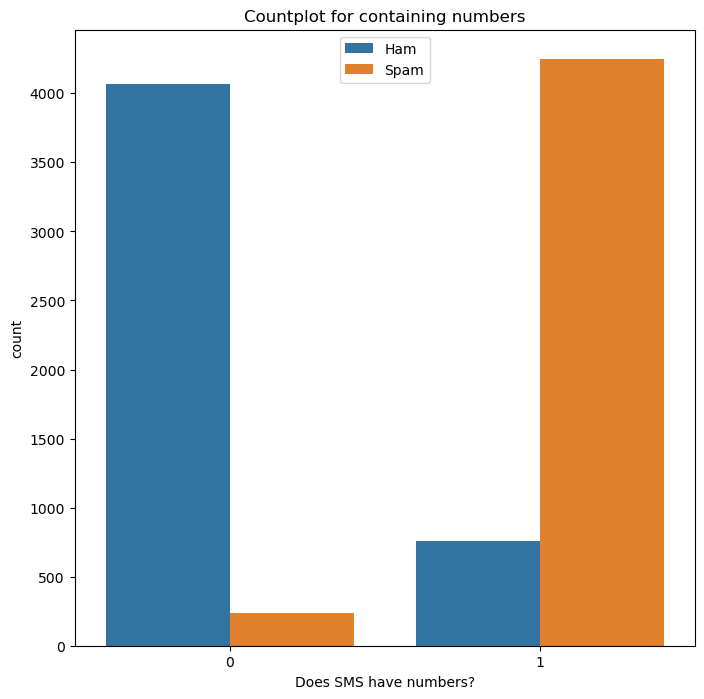

In [44]:
plt.figure(figsize=(8,8))
g=sns.countplot(x='contains_numbers',data=dataset,hue="label")
p=plt.title("Countplot for containing numbers")
p=plt.xlabel("Does SMS have numbers?")
p=plt.ylabel("count")
p=plt.legend(labels=['Ham','Spam'],loc=9)


In [45]:
#datacleaning
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
corpus = []
wnl = WordNetLemmatizer()

for sms in list(dataset.message):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms)  # Remove non-alphabetic characters
    message = message.lower()  # Convert to lowercase
    words = message.split()  # Tokenize the message into words
    filtered_words = [word for word in words if word not in set(stopwords.words("english"))]  # Remove stopwords
    lemm_words = [wnl.lemmatize(word) for word in filtered_words]  # Lemmatize the words
    message = ' '.join(lemm_words)  # Join the words back into a string
    corpus.append(message)  # Append the preprocessed message to the corpus

corpus

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though',
 'freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv',
 'even brother like speak treat like aid patent',
 'per request melle melle oru minnaminunginte nurungu vettam set callertune caller press copy friend callertune',
 'winner valued network customer selected receivea prize reward claim call claim code kl valid hour',
 'mobile month u r entitled update latest colour mobile camera free call mobile update co free',
 'gonna home soon want talk stuff anymore tonight k cried enough today',
 'six chance win cash pound txt csh send cost p day day tsandcs apply reply hl info',
 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw'

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=500)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names=tfidf.get_feature_names_out()

In [48]:
x=pd.DataFrame(vectors,columns=feature_names)
y=dataset['label']

In [49]:
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [50]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=12)

In [51]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
cv=cross_val_score(mnb,x,y,scoring='f1',cv=10)
print(round(cv.mean(),3))
print(round(cv.std(),3))

0.943
0.004


In [52]:
mnb.fit(x_train,y_train)
y_pred=mnb.predict(x_test)

In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       974
           1       0.95      0.94      0.94       888

    accuracy                           0.94      1862
   macro avg       0.94      0.94      0.94      1862
weighted avg       0.94      0.94      0.94      1862



In [54]:
cm=confusion_matrix(y_test,y_pred)
cm

array([[926,  48],
       [ 57, 831]], dtype=int64)

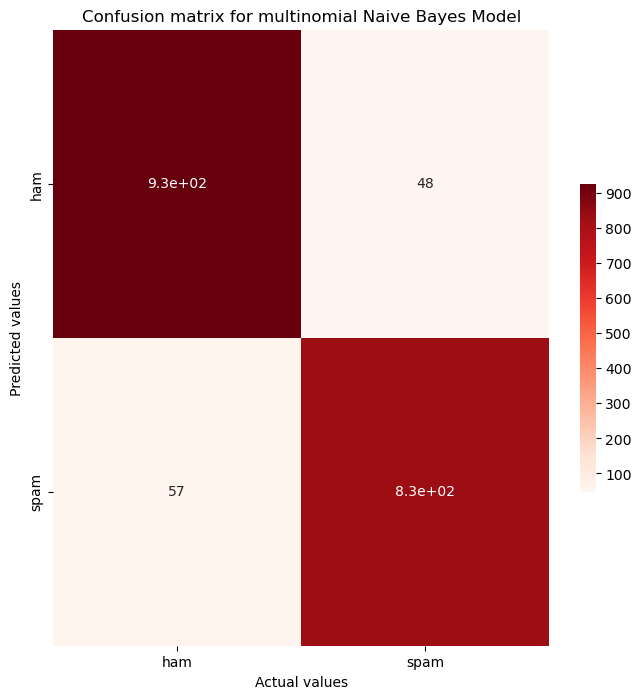

In [55]:
plt.figure(figsize=(8,8))
axis_labels=['ham','spam']
g=sns.heatmap(data=cm,xticklabels=axis_labels,yticklabels=axis_labels,annot=True,cbar_kws={'shrink':0.5},cmap="Reds")
p=plt.title("Confusion matrix for multinomial Naive Bayes Model")
p=plt.xlabel("Actual values")
p=plt.ylabel("Predicted values")

In [56]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
cv1=cross_val_score(dt,x,y,scoring='f1',cv=10)
print(round(cv1.mean(),3))
print(round(cv1.std(),3))

0.98
0.003


In [57]:
dt.fit(x_train,y_train)
y1_pred=dt.predict(x_test)

In [58]:
print(classification_report(y_test,y1_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       974
           1       0.95      1.00      0.98       888

    accuracy                           0.98      1862
   macro avg       0.98      0.98      0.98      1862
weighted avg       0.98      0.98      0.98      1862



In [59]:
cm=confusion_matrix(y_test,y1_pred)
cm

array([[932,  42],
       [  1, 887]], dtype=int64)

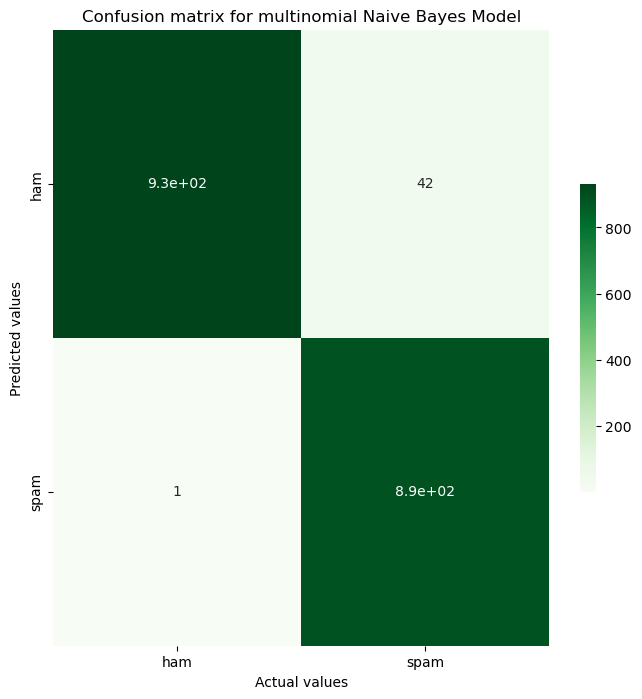

In [60]:
plt.figure(figsize=(8,8))
axis_labels=['ham','spam']
g=sns.heatmap(data=cm,xticklabels=axis_labels,yticklabels=axis_labels,annot=True,cbar_kws={'shrink':0.5},cmap="Greens")
p=plt.title("Confusion matrix for multinomial Naive Bayes Model")
p=plt.xlabel("Actual values")
p=plt.ylabel("Predicted values")

In [61]:
def predict_spam(sms):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms)  # Remove non-alphabetic characters
    message = message.lower()  # Convert to lowercase
    words = message.split()  # Tokenize the message into words
    filtered_words = [word for word in words if word not in set(stopwords.words("english"))]  # Remove stopwords
    lemm_words = [wnl.lemmatize(word) for word in filtered_words]  # Lemmatize the words
    message = ' '.join(lemm_words)  # Join the words back into a string
    temp=tfidf.transform([message]).toarray()
    return dt.predict(temp)

In [62]:
sample_message="Had your mobile 9 months or more?Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08024586030"
if predict_spam(sample_message):
    print("Gotcha! This is a spam message")
else:
    print("This is a ham message")

Gotcha! This is a spam message


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [63]:
sample_message="Hey can we meet today at 6:30?"
if predict_spam(sample_message):
    print("Gotcha! This is a spam message")
else:
    print("This is a ham message")

This is a ham message


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
